<a href="https://colab.research.google.com/github/zacharylazzara/tent-detection/blob/main/unet_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setting environment variables

%env S_PATH=/content/sarpol-zahab-tents/data
%env U_PATH=/content/unet
%env D_PATH=/content/unet/data/tent
%env T_PATH=/content/unet/data/tent/train
%env I_PATH=/content/unet/data/tent/train/image
%env L_PATH=/content/unet/data/tent/train/label
%env A_PATH=/content/unet/data/tent/train/aug
%env V_PATH=/content/unet/data/tent/test
%env N_PATH=/content/unet/data/tent/npydata

env: S_PATH=/content/sarpol-zahab-tents/data
env: U_PATH=/content/unet
env: D_PATH=/content/unet/data/tent
env: T_PATH=/content/unet/data/tent/train
env: I_PATH=/content/unet/data/tent/train/image
env: L_PATH=/content/unet/data/tent/train/label
env: A_PATH=/content/unet/data/tent/train/aug
env: V_PATH=/content/unet/data/tent/test
env: N_PATH=/content/unet/data/tent/npydata


In [2]:
# Preparing directories
# TODO: make sure we pull the specific version of unet and the dataset so that if they change in the future we don't need to update the code

%%bash
if [ ! -d $S_PATH ]; then
 git clone https://github.com/tofighi/sarpol-zahab-tents.git
 git clone https://github.com/zhixuhao/unet.git
 
 rm -r $U_PATH/data
 rm -r $U_PATH/img
 
 mkdir -p $I_PATH
 mkdir -p $L_PATH
 mkdir -p $A_PATH
 
 mkdir -p $V_PATH
 mkdir -p $N_PATH

 rm -r /content/sample_data
fi

Cloning into 'sarpol-zahab-tents'...
Cloning into 'unet'...


In [3]:
# Image Processing

#From: https://medium.com/coinmonks/learn-how-to-train-u-net-on-your-dataset-8e3f89fbd623
#Fit the data into a 256*256 format and save it as a .tif file


# TODO: need to resize the image to a size unet expects

from os import environ
from PIL import Image
from glob import glob

s_path = environ.get("S_PATH")
t_path = environ.get("T_PATH")
v_path = environ.get("V_PATH")


#input_images = [np.asarray(Image.open(path).resize((192,192))) for path in sorted(glob("{}/labels/*".format(s_path)))]
#target_masks = [np.asarray(Image.open(path).resize((192,192))) for path in sorted(glob("{}/images/*".format(s_path)))]


# TODO: make sure these lists are in the same order
imgs = list(map(Image.open, sorted(glob("{}/images/*".format(s_path)))))
lbls = list(map(Image.open, sorted(glob("{}/labels/*".format(s_path)))))

if len(imgs) == len(lbls):
  n = len(imgs)

  for i in range(n):
    # TODO: check that file names are the same
    # Any image modifications (cropping, etc) should be done here, before img.save()

    imgs[i] = imgs[i].convert("RGB").resize((256, 256))
    lbls[i] = lbls[i].convert("RGB").resize((256, 256))


    if i < n/2: # TODO: come up with a better way to divide the dataset
      imgs[i].save("{}/{}.png".format(v_path, i)) # we need to put some data in the test directory
      lbls[i].save("{}/{}_actual.png".format(v_path, i))
    else:
      imgs[i].save("{}/image/{}.tif".format(t_path, i))
      lbls[i].save("{}/label/{}.tif".format(t_path, i))

In [4]:
# Modifying unet
%%bash
sed -i '8s/.*/from tensorflow.keras.optimizers import Adam/' unet/model.py
sed -i '55s/.*/    model = Model(inputs, conv10)/' unet/model.py
sed -i "s/membrane/tent/" unet/main.py


In [5]:
# Running dataPrepare.ipynb
%cd unet/

from data import *

#if you don't want to do data augmentation, set data_gen_args as an empty dict.
#data_gen_args = dict()

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = trainGenerator(20,'data/tent/train','image','label',data_gen_args,save_to_dir = "data/tent/train/aug")


#you will see 60 transformed images and their masks in data/membrane/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break


image_arr,mask_arr = geneTrainNpy("data/tent/train/aug/","data/tent/train/aug/")
np.save("data/image_arr.npy",image_arr)
np.save("data/mask_arr.npy",mask_arr)

/content/unet
Found 128 images belonging to 1 classes.
Found 128 images belonging to 1 classes.


In [6]:
# Train Unet (trainUnet.ipynb)

from model import *
from data import *

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/tent/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_tent.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

imgs_train,imgs_mask_train = geneTrainNpy("data/tent/train/aug/","data/tent/train/aug/")
model.fit(imgs_train, imgs_mask_train, batch_size=2, epochs=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

testGene = testGenerator("data/tent/test")
model = unet()
model.load_weights("unet_tent.hdf5")
results = model.predict(testGene,30,verbose=1)
saveResult("data/tent/test",results)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Found 128 images belonging to 1 classes.
Found 128 images belonging to 1 classes.
Epoch 1/5
2000/2000 [==============================] - 1020s 490ms/step - loss: 0.0166 - accuracy: 0.9985

Epoch 00001: loss improved from inf to 0.01662, saving model to unet_tent.hdf5
Epoch 2/5
2000/2000 [==============================] - 982s 491ms/step - loss: 0.0053 - accuracy: 0.9985

Epoch 00002: loss improved from 0.01662 to 0.00525, saving model to unet_tent.hdf5
Epoch 3/5
2000/2000 [==============================] - 981s 491ms/step - loss: 0.0036 - accuracy: 0.9985

Epoch 00003: loss improved from 0.00525 to 0.00358, saving model to unet_tent.hdf5
Epoch 4/5
2000/2000 [==============================] - 980s 490ms/step - loss: 0.0030 - accuracy: 0.9987

Epoch 00004: loss improved from 0.00358 to 0.00298, saving model to unet_tent.hdf5
Epoch 5/5
2000/2000 [==============================] - 979s 489ms/step - loss: 0.0027 - accuracy: 0.9989

Epoch 00005: loss improved from 0.00298 to 0.00266, saving 

/content/unet/data.py:124: UserWarning: data/tent/test/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/3_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/4_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/5_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
/content/unet/data.py:124: UserWarning: data/tent/test/6_predict.png is a low cont

label shape: (count, width, height, channels)
a_lbl shape:  (30, 256, 256, 3)
p_lbl shape:  (30, 256, 256, 3)
c_lbl shape:  (60, 256, 256, 3)


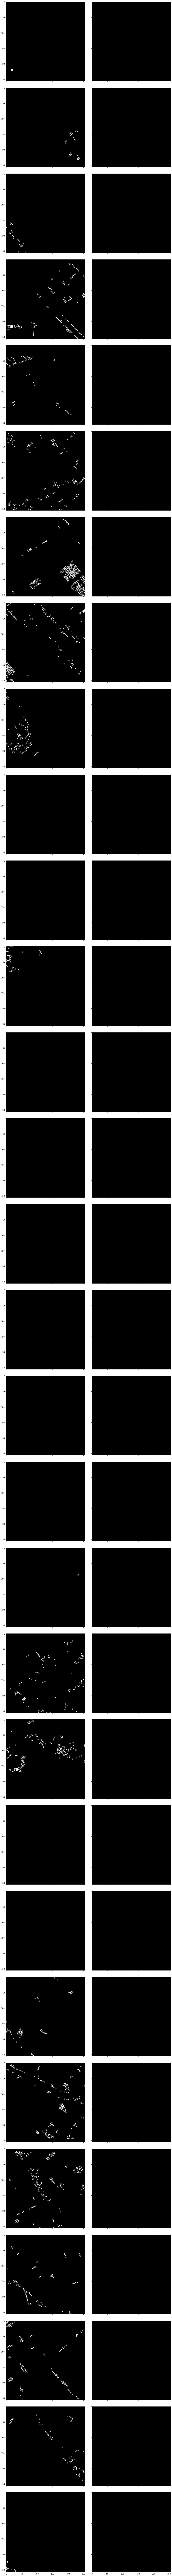

In [7]:
# View Results

from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

v_path = environ.get("V_PATH")

p_lbls = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/*predict.png".format(v_path)))])
a_lbls = np.array([np.asarray(Image.open(path).convert('RGB')) for path in sorted(glob("{}/*actual.png".format(v_path)))][:p_lbls.shape[0]])

print("label shape: (count, width, height, channels)")
print("a_lbl shape: ", a_lbls.shape)
print("p_lbl shape: ", p_lbls.shape)

# If shapes aren't equal this won't work
c_lbls = np.array([img for arr in np.stack((a_lbls, p_lbls), axis=1) for img in arr])

print("c_lbl shape: ", c_lbls.shape)

n = int(c_lbls.shape[0]/2)

fig = plt.figure(figsize=(c_lbls.shape[1], c_lbls.shape[2]))
grid = ImageGrid(fig, 111, nrows_ncols=(n, 2), axes_pad=0.5)

for ax, im in zip(grid, c_lbls):
  ax.imshow(im)

plt.show()